In [1]:
import importlib
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [2]:
os.chdir(os.getcwd() + '/src/')
os.getcwd()
import utils as utils
import gmm as gmm

In [3]:
test_rng: np.random.Generator = np.random.default_rng(42)
k = 2
dim = 2

def reload():
    importlib.reload(gmm)
    importlib.reload(utils)

[[3.80610686 4.68346603]
 [1.40727059 1.57255309]]


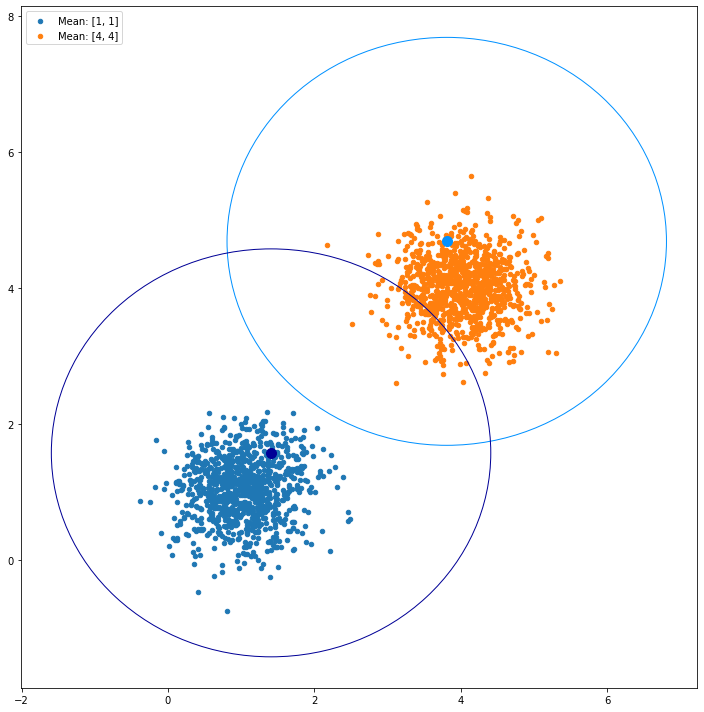

In [4]:
cluster_means = [
    [1, 1],
    [4, 4],
]
initial_data, fig, ax = utils.generate_clustered_data(dim, k, cluster_means, num_points_per_cluster=1000, plot=True, spread_factor=0.05)
shuffle_data = test_rng.permutation(initial_data)
gmm_init_data = shuffle_data[:k]
print(gmm_init_data)
gmm = gmm.GMM(0, 2)
gmm.initialize(gmm_init_data)
utils.plot_gaussians(gmm.means, gmm.covariances, ax)

In [8]:
gmm.log_likelihood(shuffle_data)

-5934.370731760906

In [ ]:
nb_iter = 10
batch_size = 100
for i in range(nb_iter):
    print(f'Current ll {gmm.log_likelihood(shuffle_data)}.')
    samples = shuffle_data[test_rng.choice(len(shuffle_data), size=batch_size)]
    print(f'Coefficients are {gmm.coefficients}; Means are {gmm.means}')
    print(f'Maxima in covs are {[np.max(c) for c in gmm.covariances]}')
    samples = shuffle_data[test_rng.choice(len(shuffle_data), size=batch_size)]
    before = gmm.log_likelihood(samples)
    gmm.online_EM(samples, gamma=0.01)
    after = gmm.log_likelihood(samples)
    print(f'--------- ll shifted from {before} to {after} ----------')

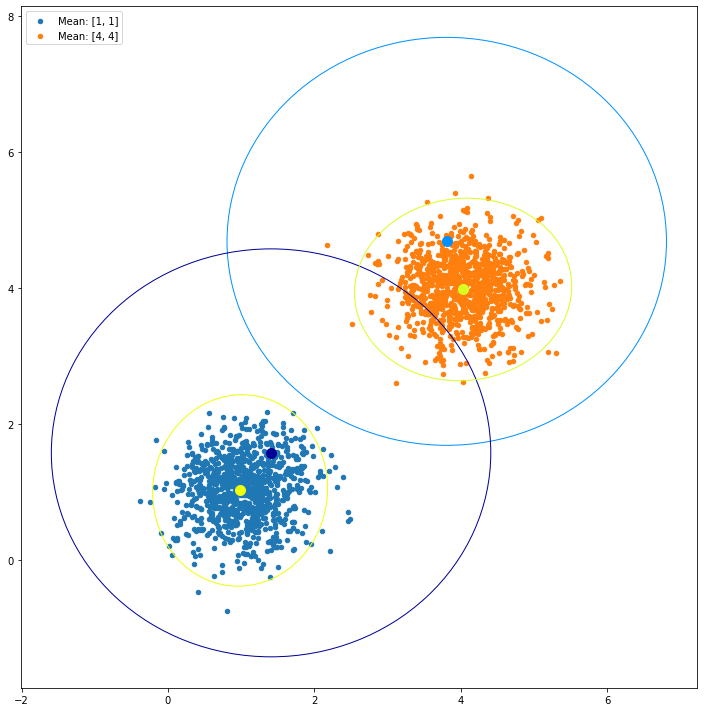

In [10]:
utils.plot_gaussians(gmm.means, gmm.covariances, ax)
fig